## Importing the libraries

In [30]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns
plt.style.use('fivethirtyeight')

In [31]:
data=pd.read_csv('../dataset/Seethaeliya1.csv')
##importing the data

In [32]:
data.head()
##watching head values of dataset

,Date,T_Max,T_Min,RH_1,RH_2,Wind_speed,sunshine_hours,rainfall,evaporation
0,1/1/2016,16.8,12.4,100.0,98.0,13.75,0.0,8.5,1.16
1,1/2/2016,16.2,11.4,98.0,98.0,6.66,3.0,2.3,0.97
2,1/3/2016,18.8,12.0,92.0,98.0,5.92,5.8,0.0,1.58
3,1/4/2016,19.8,12.6,94.0,94.0,4.63,7.1,0.0,1.84
4,1/5/2016,20.2,14.8,96.0,74.0,5.52,10.4,0.2,1.47


In [33]:
data.shape
##the shape of the dataset

(2192, 9)

In [34]:
##converting date and time
data['Date']=pd.to_datetime(data['Date'])

In [35]:
##We will need to remove the T_max feature because there are so much null values
##remove the T_Max column
data=data.drop(['T_Max'],axis=1)

In [36]:
data.set_index('Date',inplace=True) ##indexing

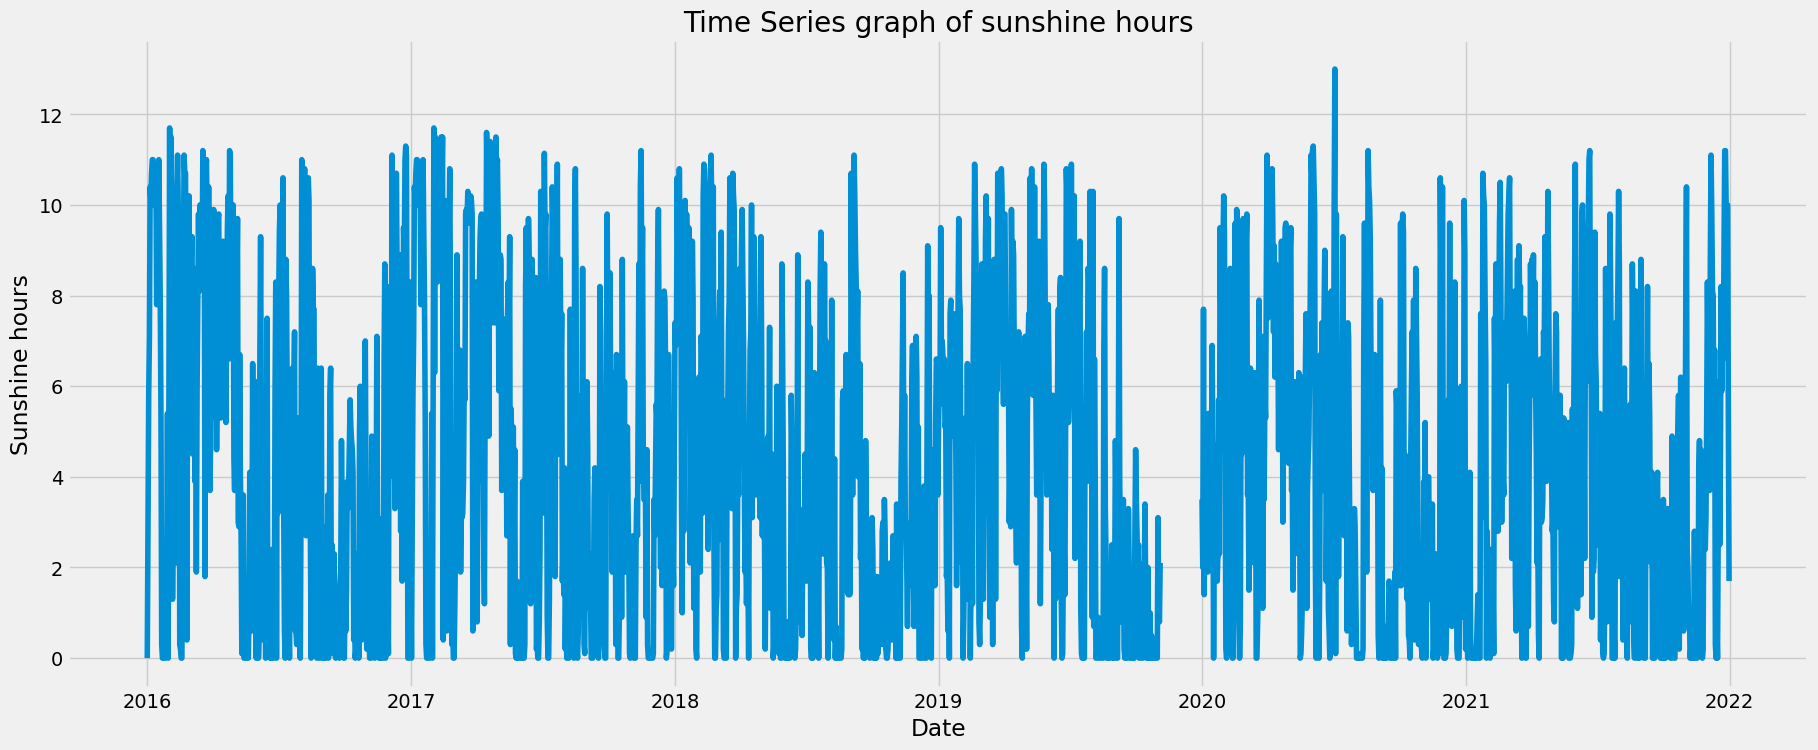

In [37]:
##time series plot of sunshine hours
plt.figure(figsize=(20,8))
plt.plot(data['sunshine_hours'])
plt.title('Time Series graph of sunshine hours')
plt.xlabel('Date')
plt.ylabel('Sunshine hours')
plt.show()

In [38]:
data.head()

,T_Min,RH_1,RH_2,Wind_speed,sunshine_hours,rainfall,evaporation
Date,,,,,,,
2016-01-01,12.4,100.0,98.0,13.75,0.0,8.5,1.16
2016-01-02,11.4,98.0,98.0,6.66,3.0,2.3,0.97
2016-01-03,12.0,92.0,98.0,5.92,5.8,0.0,1.58
2016-01-04,12.6,94.0,94.0,4.63,7.1,0.0,1.84
2016-01-05,14.8,96.0,74.0,5.52,10.4,0.2,1.47


In [39]:
##create a new dataframe with only the sunshinehours column
data5=data.filter(['sunshine_hours'])
data5=data5.interpolate() ##handle null values with linear interpolation
##convert the dataframe into a numpy array
dataset5=data5.values
##get the number of rows to train the model
train_data_len=math.ceil(len(dataset5)*.8)

train_data_len

1754

In [40]:
data5

,sunshine_hours
Date,
2016-01-01,0.0
2016-01-02,3.0
2016-01-03,5.8
2016-01-04,7.1
2016-01-05,10.4
...,...
2021-12-27,9.9
2021-12-28,10.0
2021-12-29,10.0


In [41]:
data5.apply(pd.isnull).sum() ##check null values after interpolation

sunshine_hours    0
dtype: int64

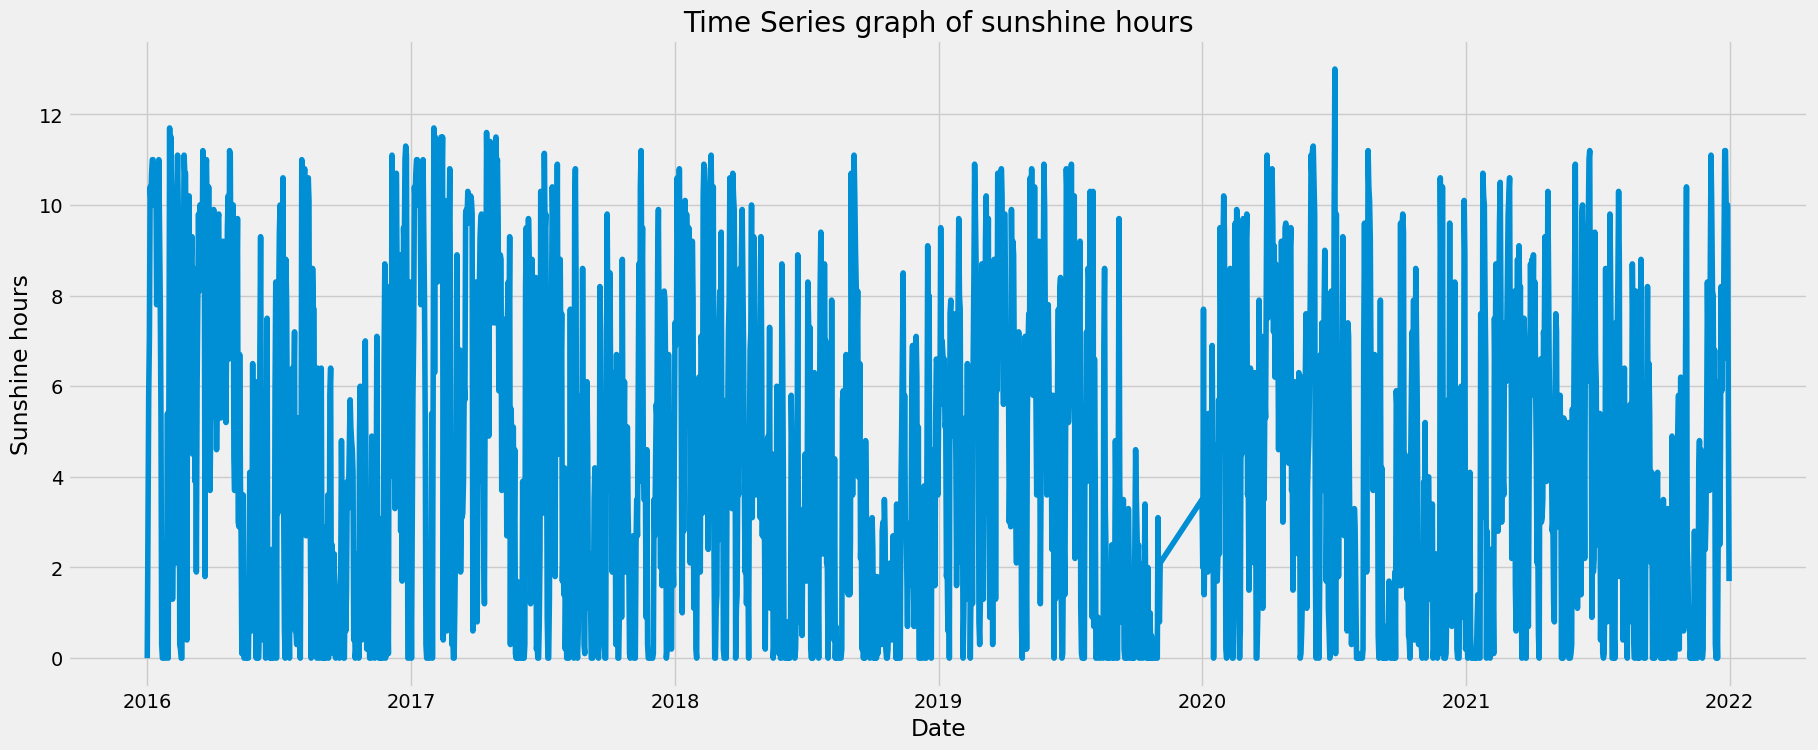

In [42]:
##time series plot of sunshine hours
plt.figure(figsize=(20,8))
plt.plot(data5['sunshine_hours'])
plt.title('Time Series graph of sunshine hours')
plt.xlabel('Date')
plt.ylabel('Sunshine hours')
plt.show()

In [43]:
##Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
sc=scaler.fit_transform(dataset5)
sc

array([[0.        ],
       [0.23076923],
       [0.44615385],
       ...,
       [0.76923077],
       [0.40769231],
       [0.13076923]])

In [44]:
#Create the training data set
##create the scaled training data set
train_data=sc[0:train_data_len,:]
##split the data into x_train and y_train data sets

x_train=[] ##features
y_train=[] ##target

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.23076923, 0.44615385, 0.54615385, 0.8       ,
       0.77692308, 0.82307692, 0.84615385, 0.84615385, 0.76923077,
       0.81538462, 0.83846154, 0.82307692, 0.6       , 0.66153846,
       0.60769231, 0.84615385, 0.73076923, 0.60769231, 0.40769231,
       0.02307692, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03846154, 0.12307692, 0.41538462, 0.        ,
       0.42307692, 0.9       , 0.48461538, 0.88461538, 0.72307692,
       0.1       , 0.27692308, 0.26923077, 0.28461538, 0.30769231,
       0.16153846, 0.78461538, 0.85384615, 0.75384615, 0.72307692,
       0.02307692, 0.01538462, 0.        , 0.        , 0.52307692,
       0.63076923, 0.85384615, 0.82307692, 0.82307692, 0.53846154,
       0.03076923, 0.74615385, 0.61538462, 0.78461538, 0.4       ])]
[0.5923076923076923]



In [45]:
##convert train sets to numpyarrays
x_train,y_train=np.array(x_train),np.array(y_train)
x_train
y_train
##here we have 2d array
##but dealing with LSTM we need to have 3d array
##therefore it is needed to reshape the data

array([0.59230769, 0.68461538, 0.71538462, ..., 0.45384615, 0.55384615,
       0.36153846])

In [46]:
##reshape the data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1694, 60, 1)

## Model Building

In [47]:
model=Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,activation='relu',return_sequences=False))
model.add(Dense(25,activation='relu'))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

##train the model
history = model.fit(x_train,y_train,epochs=10,batch_size=1)

Epoch 1/10
1694/1694 [==============================] - 38s 20ms/step - loss: 0.0581
Epoch 2/10
1694/1694 [==============================] - 35s 21ms/step - loss: 0.0466
Epoch 3/10
1694/1694 [==============================] - 34s 20ms/step - loss: 0.0445
Epoch 4/10
1694/1694 [==============================] - 38s 22ms/step - loss: 0.0443
Epoch 5/10
1694/1694 [==============================] - 37s 22ms/step - loss: 0.0434
Epoch 6/10
1694/1694 [==============================] - 38s 22ms/step - loss: 0.0434
Epoch 7/10
1694/1694 [==============================] - 38s 22ms/step - loss: 0.0433
Epoch 8/10
1694/1694 [==============================] - 38s 22ms/step - loss: 0.0431
Epoch 9/10
1694/1694 [==============================] - 37s 22ms/step - loss: 0.0433
Epoch 10/10
1694/1694 [==============================] - 38s 22ms/step - loss: 0.0433


Text(0.5, 1.0, 'Model Accuracy')

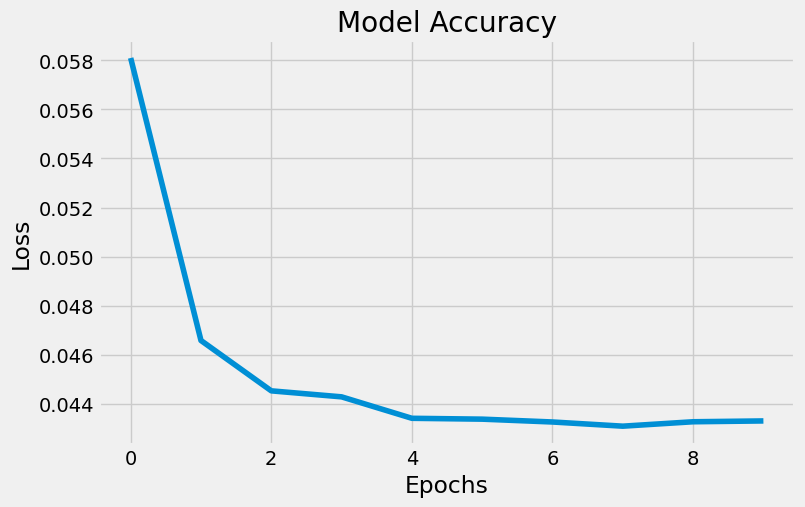

In [48]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [21]:
##create the testing dataset
##create a new array containing scaled values from index 1694 to 2192
test_data=sc[train_data_len-60:,:]
##Create data set x_test and y_test
x_test=[]
y_test=dataset5[train_data_len:,:]

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    

In [22]:
##convert the data into numpy array
x_test=np.array(x_test)

In [23]:
##reshape the dataset
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [24]:
##get the models predicted sunshine hours
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions) ##unscaling

14/14 [==============================] - 1s 22ms/step


In [25]:
##calculate RMSE
##lower the RMSE higher the accuracy
rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
rmse

2.7244375246909125

C:\Users\Chalaka\AppData\Local\Temp\ipykernel_17752\444241433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Predictions']=predictions


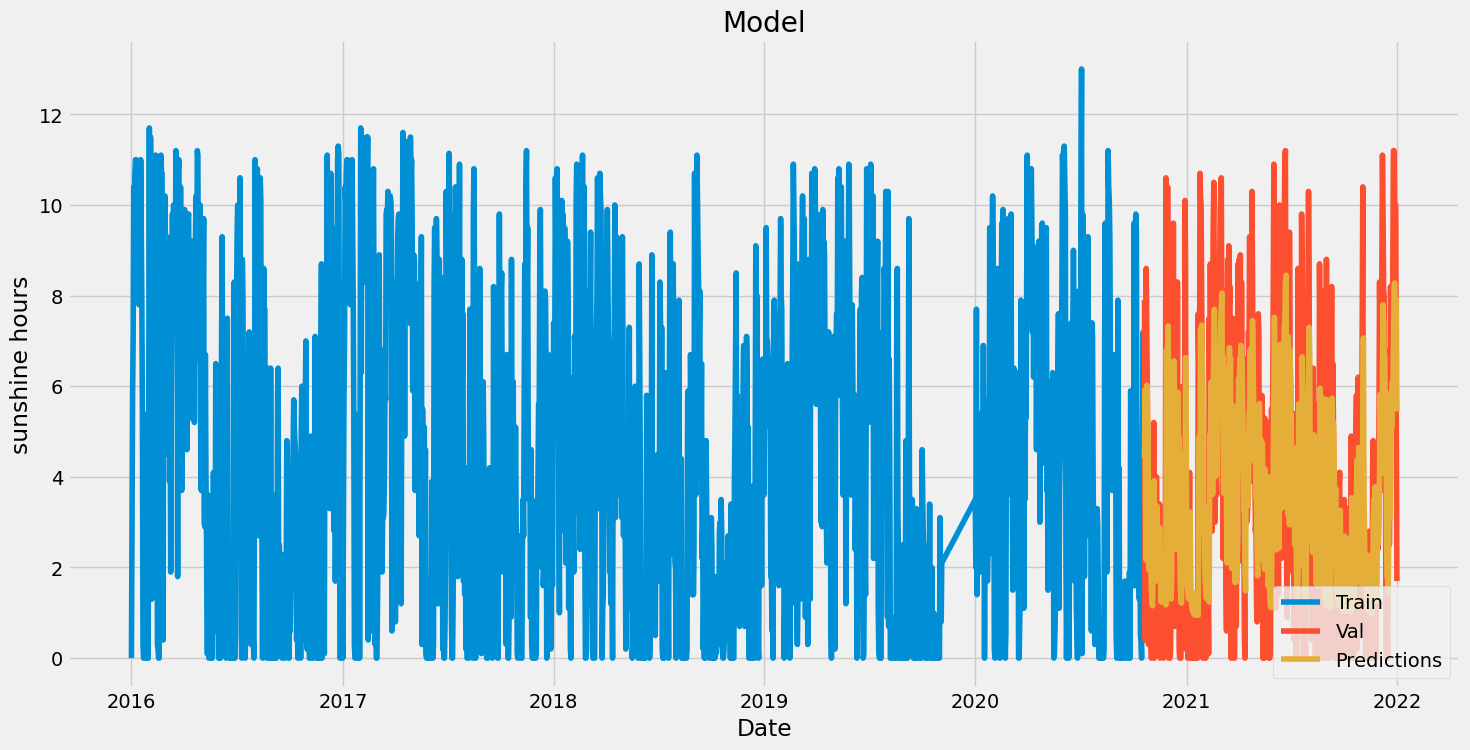

In [26]:
##plot the data
train=data5[:train_data_len]
validation_data=data5[train_data_len:]
validation_data['Predictions']=predictions

##visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('sunshine hours')
plt.plot(train['sunshine_hours'])
plt.plot(validation_data[['sunshine_hours','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

## Prediction for the next day Sunshine hours

In [27]:
##get the quote
data5_quote=pd.read_csv('../dataset/Seethaeliya1.csv')

In [28]:
data5_quote.set_index('Date',inplace=True)

In [29]:
##create a new dataframe
new_data5=data5_quote.filter(['sunshine_hours'])
##get the last 60 day sunshine hours and convert the dataframe to an array
last_60=new_data5[-60:].values
##scale the data between 0 and 1
sc_last_60=scaler.transform(last_60)
##Create an empty list
X_test=[]
##Append the past days
X_test.append(sc_last_60)
##convert the X_test data to numpy array
X_test=np.array(X_test)
##reshape the data
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
##Get the predicted scaled sunshine hours
pred_sh=model.predict(X_test)
##undo the scaling
pred_sh=scaler.inverse_transform(pred_sh)
print(pred_sh) ##sunshine hours for 2022-01-01

1/1 [==============================] - 0s 42ms/step
[[3.23477]]


In [98]:
##actual value=6.8